## Import des bibliothèques

In [5]:
import sqlite3
import pandas as pd
import json
import numpy as np

## Import de la base

In [ ]:
conn = sqlite3.connect("data/strava.db")
df = pd.read_sql("SELECT * FROM strava_activities", conn)

print(df.head())

   id  athlete_id  activity_id                                      name  \
0   1    32883472  15457990537           Course à pied dans l'après-midi   
1   2    32883472  15447272782           Course à pied dans l'après-midi   
2   3    32883472  15434809048           Course à pied dans l'après-midi   
3   4    32883472  15422627828  Entraînement aux poids dans l'après-midi   
4   5    32883472  15399467108            Entraînement dans l'après-midi   

             type                  start_date  distance  moving_time  \
0             Run  2025-08-14 15:40:32.000000    7528.0         2365   
1             Run  2025-08-13 15:59:42.000000   15234.0         4968   
2             Run  2025-08-12 15:50:20.000000    8149.3         2728   
3  WeightTraining  2025-08-11 15:35:49.000000       0.0         2317   
4         Workout  2025-08-09 13:10:36.000000       0.0         1641   

   elapsed_time  total_elevation_gain  ...  suffer_score  zone_1_time  \
0          2383                  20.0

## Nettoyage des données

In [20]:
MIN_SPEED_MPS = 0.1  # 0.5 m/s = 0.36 km/h
MAX_SPEED_MPS = 6  # 6 m/s = 21.6 km/h

# 1. FILTRER POUR N'AVOIR QUE LES RUNS
print("Types d'activités disponibles:")
print(df['type'].value_counts())

# Filtrer pour ne garder que les activités de course à pied
runs_df = df[df['type'] == 'Run'].copy()
print(f"\nNombre total d'activités: {len(df)}")
print(f"Nombre d'activités de course: {len(runs_df)}")

# 2. FILTRER POUR LES RUNS AVEC DONNÉES COMPLÈTES
runs_with_data = runs_df.dropna(subset=['elevation_data', 'pace_data', 'heartrate_data'])
print(f"Nombre de runs avec données complètes: {len(runs_with_data)}")

if len(runs_with_data) == 0:
    print("❌ Aucune activité de course avec des données complètes trouvée")
else:
    # 3. PRENDRE LA PREMIÈRE ACTIVITÉ AVEC DONNÉES COMPLÈTES
    activity = runs_with_data.iloc[0]
    print(f"\n✅ Traitement de l'activité: {activity['name']}")
    print(f"   Distance: {activity['distance']/1000:.2f} km")
    print(f"   Date: {activity['start_date']}")
    
    # 4. EXTRAIRE LES DONNÉES JSON
    elev = activity["elevation_data"]
    pace = activity["pace_data"]
    hr = activity["heartrate_data"]

    # Parser les données JSON si nécessaire
    if isinstance(elev, str):
        elev = json.loads(elev)
    if isinstance(pace, str):
        pace = json.loads(pace)
    if isinstance(hr, str):
        hr = json.loads(hr)
    
    # 5. VÉRIFIER LA STRUCTURE DES DONNÉES
    print(f"\nStructure des données:")
    print(f"  - Élévation: {type(elev)} avec clés: {list(elev.keys()) if isinstance(elev, dict) else 'Non un dict'}")
    print(f"  - Rythme: {type(pace)} avec clés: {list(pace.keys()) if isinstance(pace, dict) else 'Non un dict'}")
    print(f"  - Fréquence cardiaque: {type(hr)} avec clés: {list(hr.keys()) if isinstance(hr, dict) else 'Non un dict'}")
    
    # 6. TRAITER LES DONNÉES SI ELLES SONT VALIDES
    if isinstance(elev, dict) and "distance" in elev and "altitude" in elev:
        if isinstance(pace, dict) and "distance" in pace and "time" in pace:
            if isinstance(hr, dict) and "heartrate" in hr:
                
                # Extraire les arrays
                d_alt = np.array(elev["distance"])
                alt = np.array(elev["altitude"])
                d_pace = np.array(pace["distance"])
                t_pace = np.array(pace["time"])
                heart_rate = np.array(hr["heartrate"])
                
                print(f"\nNombre de points de données:")
                print(f"  - Élévation: {len(d_alt)} points")
                print(f"  - Rythme: {len(d_pace)} points")
                print(f"  - Fréquence cardiaque: {len(heart_rate)} points")

                # Interpolation sur grille commune
                min_common = max(d_alt[0], d_pace[0])
                max_common = min(d_alt[-1], d_pace[-1])

                d_ref = np.linspace(min_common, max_common, min(len(d_alt), len(d_pace)))

                alt_ref = np.interp(d_ref, d_alt, alt)
                t_ref = np.interp(d_ref, d_pace, t_pace)
                hr_ref = np.interp(d_ref, d_pace, heart_rate)

                # Calculs
                pente = np.gradient(alt_ref, d_ref * 1000) * 100
                vitesse = np.gradient(d_ref * 1000, t_ref)  # Vitesse en m/s

                mask = np.isfinite(pente) & np.isfinite(vitesse) & (vitesse > MIN_SPEED_MPS) & (vitesse < MAX_SPEED_MPS)
                max_pente = np.max(pente[mask])
                print(max_pente)
                min_pente = np.min(pente[mask])
                print(min_pente)
                print(f"\n📊 Résultats:")
                print(f"Points valides: {np.sum(mask)}/{len(mask)}")
                if np.sum(mask) > 0:
                    print(f"Pente moyenne: {np.mean(pente[mask]):.2f}%")
                    print(f"Vitesse moyenne: {np.mean(vitesse[mask]):.2f} m/s ({np.mean(vitesse[mask])*3.6:.1f} km/h)")
                    print(f"FC moyenne: {np.mean(hr_ref[mask]):.0f} bpm")
                else:
                    print("❌ Aucun point valide après filtrage")
            else:
                print("❌ Données de fréquence cardiaque invalides")
        else:
            print("❌ Données de rythme invalides")
    else:
        print("❌ Données d'élévation invalides")


Types d'activités disponibles:
type
Run               103
WeightTraining     21
AlpineSki          13
Hike                8
Workout             5
Ride                1
Name: count, dtype: int64

Nombre total d'activités: 151
Nombre d'activités de course: 103
Nombre de runs avec données complètes: 103

✅ Traitement de l'activité: Course à pied dans l'après-midi
   Distance: 7.53 km
   Date: 2025-08-14 15:40:32.000000

Structure des données:
  - Élévation: <class 'dict'> avec clés: ['distance', 'altitude']
  - Rythme: <class 'dict'> avec clés: ['time', 'distance', 'velocity']
  - Fréquence cardiaque: <class 'dict'> avec clés: ['time', 'heartrate']

Nombre de points de données:
  - Élévation: 2368 points
  - Rythme: 2368 points
  - Fréquence cardiaque: 2368 points
15.721307120089634
-15.721307120089634

📊 Résultats:
Points valides: 2367/2368
Pente moyenne: -0.06%
Vitesse moyenne: 3.27 m/s (11.8 km/h)
FC moyenne: 156 bpm


In [91]:
from scipy.signal import savgol_filter

MIN_SPEED_MPS = 0.1  # 0.36 km/h
MAX_SPEED_MPS = 6    # 21.6 km/h

results = []
points = []
points_segments = []

for i, activity in runs_with_data.iterrows():
    elev = activity["elevation_data"]
    pace = activity["pace_data"]
    hr = activity["heartrate_data"]

    # Parser JSON si nécessaire
    if isinstance(elev, str):
        elev = json.loads(elev)
    if isinstance(pace, str):
        pace = json.loads(pace)
    if isinstance(hr, str):
        hr = json.loads(hr)

    # Vérification basique des clés
    if not (isinstance(elev, dict) and "distance" in elev and "altitude" in elev):
        continue
    if not (isinstance(pace, dict) and "distance" in pace and "time" in pace):
        continue
    if not (isinstance(hr, dict) and "heartrate" in hr):
        continue

    # Extraction
    d_alt = np.array(elev["distance"])
    alt = np.array(elev["altitude"])
    d_pace = np.array(pace["distance"])
    t_pace = np.array(pace["time"])
    heart_rate = np.array(hr["heartrate"])

    # Interpolation sur grille commune
    min_common = max(d_alt[0], d_pace[0])
    max_common = min(d_alt[-1], d_pace[-1])
    d_ref = np.linspace(min_common, max_common, min(len(d_alt), len(d_pace)))
    print(d_ref)
    alt_ref = np.interp(d_ref, d_alt, alt)
    t_ref = np.interp(d_ref, d_pace, t_pace)
    hr_ref = np.interp(d_ref, d_pace, heart_rate)

    # ⚡️ Lissage de l'altitude avec Savitzky-Golay
    # window_length doit être impair et <= len(alt_ref)
    window_length = min(len(alt_ref) // 5 * 2 + 1, 51)  # borne max 51
    if window_length < 5:  # pas assez de points pour lisser
        continue
    alt_smooth = savgol_filter(alt_ref, window_length=window_length, polyorder=2)

    # Pente sur segments (10 m)
    segment = 10  # m
    pente_local = []
    for i in range(len(d_ref) - 1):
        for j in range(i+1, len(d_ref)):
            delta_dist = (d_ref[j] - d_ref[i]) * 1000
            if delta_dist >= segment:
                delta_alt = alt_smooth[j] - alt_smooth[i]
                pente_local.append((delta_alt / delta_dist) * 100)
                pente_seg = (delta_alt / delta_dist) * 100

                # temps sur le segment
                delta_t = t_ref[j] - t_ref[i]

                # FC moyenne sur le segment
                fc_seg = np.mean(hr_ref[i:j+1])

                points_segments.append({
                    "distance_start_m": d_ref[i]*1000,
                    "distance_end_m": d_ref[j]*1000,
                    "delta_t_s": delta_t,
                    "pente": pente_seg,
                    "fc_moy": fc_seg
                })
                break
    pente_local = np.array(pente_local)

    if pente_local.size == 0:
        continue

    # Vitesse
    vitesse = np.gradient(d_ref * 1000, t_ref)  # m/s

    # Masque pour garder que les points valides
    mask = np.isfinite(vitesse) & (vitesse > MIN_SPEED_MPS) & (vitesse < MAX_SPEED_MPS)

    if np.sum(mask) == 0:
        continue

    # ⚡️ Stocker aussi chaque point individuel
    points.extend([
        {
            "distance_km": d_ref[k] / 1000,
            "pente": pente_local[k],
            "vitesse_mps": vitesse[k] * 3.6,
            "fc": hr_ref[k]
        }
        for k in range(len(pente_local)) if mask[k]
    ])

    # Stocker les résultats
    results.append({
        "id": activity["id"],
        "name": activity["name"],
        "date": activity["start_date"],
        "distance_km": activity["distance"] / 1000,
        "pente_max": np.quantile(pente_local, 0.99),  # pente "max réaliste"
        "pente_min": np.quantile(pente_local, 0.01),  # pente "min réaliste"
        "pente_moy": np.mean(pente_local),
        "vitesse_moy_mps": np.mean(vitesse[mask]),
        "vitesse_moy_kmh": np.mean(vitesse[mask]) * 3.6,
        "fc_moy": np.mean(hr_ref[mask])
    })

# Résumé final dans un DataFrame
summary_df = pd.DataFrame(results)
points_df = pd.DataFrame(points)
points_segments_df = pd.DataFrame(points_segments)
# Calcul des quantiles
q_low = points_df["pente"].quantile(0.01)
q_high = points_df["pente"].quantile(0.99)
seg_q_low = points_segments_df["pente"].quantile(0.01)
seg_q_high = points_segments_df["pente"].quantile(0.99)


# Filtrer
points_df = points_df[(points_df["pente"] >= q_low) & (points_df["pente"] <= q_high)]
points_segments_df = points_segments_df[(points_segments_df["pente"] >= seg_q_low) & (points_segments_df["pente"] <= seg_q_high)]
fc_min = 120
fc_max = 180
points_df = points_df[(points_df["fc"] >= fc_min) & (points_df["fc"] <= fc_max)]
points_segments_df = points_segments_df[(points_segments_df["fc_moy"] >= fc_min) & (points_segments_df["fc_moy"] <= fc_max)]

print("\nRésumé global:")
print(summary_df[["name", "distance_km", "pente_max", "pente_min", "vitesse_moy_kmh", "fc_moy"]].head())

print(f"\nPente max rencontrée: {summary_df['pente_max'].max():.2f} %")
print(f"Pente min rencontrée: {summary_df['pente_min'].min():.2f} %")


# Trouver la sortie avec la pente max
idx_max = summary_df['pente_max'].idxmax()
sortie_max = summary_df.loc[idx_max]

print("Sortie avec pente max :")
print(sortie_max)

# Idem pour la pente min
idx_min = summary_df['pente_min'].idxmin()
sortie_min = summary_df.loc[idx_min]

print("\nSortie avec pente min :")
print(sortie_min)


print("\nTableau détaillé (par point) :")
print(points_df.head())
print(points_df.tail())


[0.00000000e+00 3.18039713e-03 6.36079425e-03 ... 7.52163921e+00
 7.52481960e+00 7.52800000e+00]
[0.00000000e+00 3.06580801e-03 6.13161602e-03 ... 1.52278684e+01
 1.52309342e+01 1.52340000e+01]
[0.00000000e+00 2.98509158e-03 5.97018315e-03 ... 8.14332982e+00
 8.14631491e+00 8.14930000e+00]
[0.00000000e+00 2.12363168e-03 4.24726336e-03 ... 3.29375274e+00
 3.29587637e+00 3.29800000e+00]
[0.00000000e+00 2.58683673e-03 5.17367347e-03 ... 5.06502633e+00
 5.06761316e+00 5.07020000e+00]
[0.00000000e+00 2.20742024e-03 4.41484049e-03 ... 4.33095852e+01
 4.33117926e+01 4.33140000e+01]
[0.00000000e+00 2.92417860e-03 5.84835720e-03 ... 3.46515164e+00
 3.46807582e+00 3.47100000e+00]
[0.00000000e+00 3.18154613e-03 6.36309227e-03 ... 6.37263691e+00
 6.37581845e+00 6.37900000e+00]
[0.00000000e+00 2.96618766e-03 5.93237532e-03 ... 1.05210676e+01
 1.05240338e+01 1.05270000e+01]
[0.00000000e+00 3.06476684e-03 6.12953368e-03 ... 1.06408705e+01
 1.06439352e+01 1.06470000e+01]
[0.00000000e+00 2.78616134e-03

/var/folders/sm/4fxx128x4lb_h0nj_mjr0lvm0000gn/T/ipykernel_26102/1901845698.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  points_df = points_df.groupby("pente_bin", group_keys=False).apply(


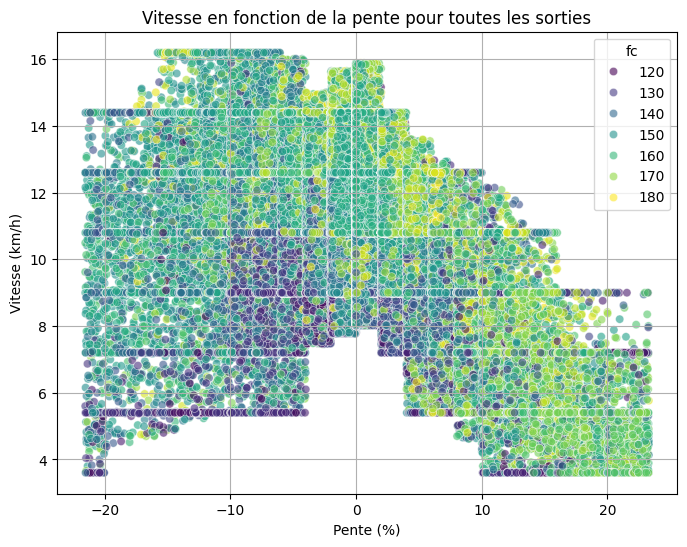

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns

points_df["pente_bin"] = (points_df["pente"] // 2) * 2  # bin de 2%
points_df = points_df.groupby("pente_bin", group_keys=False).apply(
    lambda g: g[g["vitesse_kmh"].between(g["vitesse_kmh"].quantile(0.01), g["vitesse_kmh"].quantile(0.99))]
).reset_index(drop=True)

# Nuage de points : vitesse en fonction de la pente
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=points_df,
    x="pente",
    y="vitesse_kmh",
    hue="fc",
    palette="viridis",
    alpha=0.6
)
plt.xlabel("Pente (%)")
plt.ylabel("Vitesse (km/h)")
plt.title("Vitesse en fonction de la pente pour toutes les sorties")
plt.grid(True)
plt.show()

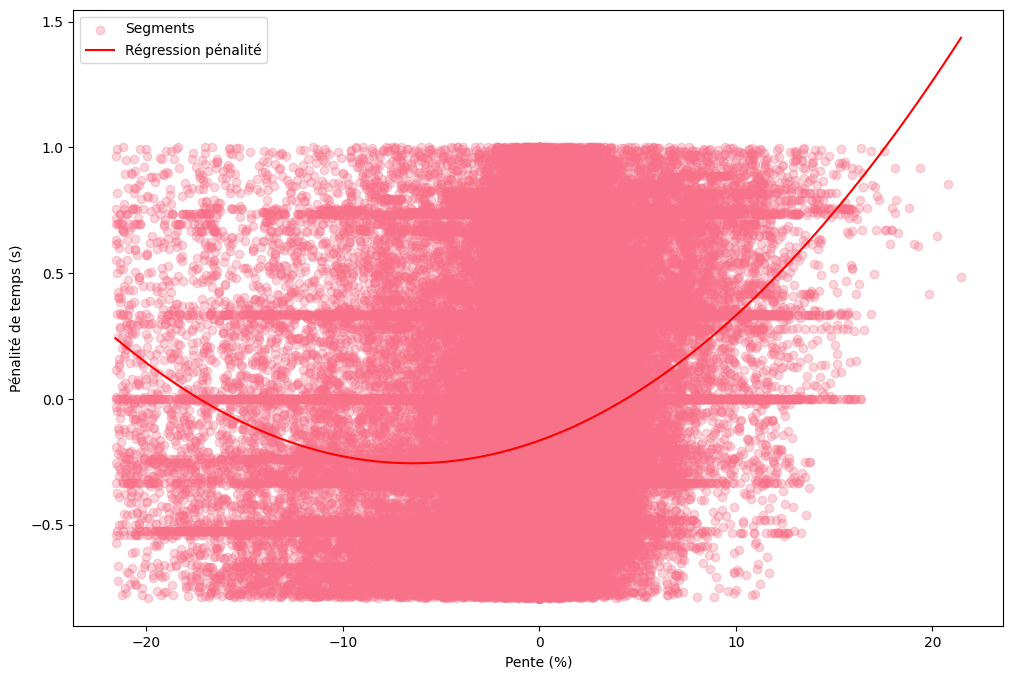

In [90]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt


vitesse_plat = 3

# Calcul pénalité temps en secondes
points_segments_df["distance_m"] = points_segments_df["distance_end_m"] - points_segments_df["distance_start_m"]
points_segments_df["t_plat"] = points_segments_df["distance_m"] / vitesse_plat
points_segments_df["penalite_s"] = points_segments_df["delta_t_s"] - points_segments_df["t_plat"]

seg_q_low = points_segments_df["penalite_s"].quantile(0.01)
seg_q_high = points_segments_df["penalite_s"].quantile(0.99)
points_segments_df = points_segments_df[(points_segments_df["penalite_s"] >= seg_q_low) & (points_segments_df["penalite_s"] <= seg_q_high)]


X = points_segments_df["pente"].values.reshape(-1, 1)
y = points_segments_df["penalite_s"].values

degree = 2
model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
model.fit(X, y)

# Prédiction
pente_test = np.linspace(points_segments_df["pente"].min(), points_segments_df["pente"].max(), 100).reshape(-1, 1)
penalite_pred = model.predict(pente_test)

# Visualisation
plt.scatter(points_segments_df["pente"], points_segments_df["penalite_s"], alpha=0.3, label="Segments")
plt.plot(pente_test, penalite_pred, color='red', label="Régression pénalité")
plt.xlabel("Pente (%)")
plt.ylabel("Pénalité de temps (s)")
plt.legend()
plt.show()

In [114]:

from scipy import interpolate
tableau = []
d_seg = 10 # m
vm = 3

for i, activity in runs_with_data.iterrows():
    elev = activity["elevation_data"]
    pace = activity["pace_data"]
    hr = activity["heartrate_data"]

    # Parser JSON si nécessaire
    if isinstance(elev, str):
        elev = json.loads(elev)
    if isinstance(pace, str):
        pace = json.loads(pace)
    if isinstance(hr, str):
        hr = json.loads(hr)

    # Vérification basique des clés
    if not (isinstance(elev, dict) and "distance" in elev and "altitude" in elev):
        continue
    if not (isinstance(pace, dict) and "distance" in pace and "time" in pace):
        continue
    if not (isinstance(hr, dict) and "heartrate" in hr):
        continue

    # Extraction
    d_alt = np.array(elev["distance"])
    alt = np.array(elev["altitude"])
    d_pace = np.array(pace["distance"])
    t_pace = np.array(pace["time"])
    heart_rate = np.array(hr["heartrate"])

    # Interpolation sur grille commune
    min_common = max(d_alt[0], d_pace[0])
    max_common = min(d_alt[-1], d_pace[-1])
    d_ref = np.linspace(min_common, max_common, min(len(d_alt), len(d_pace)))

    alt_ref = np.interp(d_ref, d_alt, alt)
    t_ref = np.interp(d_ref, d_pace, t_pace)
    hr_ref = np.interp(d_ref, d_pace, heart_rate)

    # ⚡️ Lissage de l'altitude avec Savitzky-Golay
    # window_length doit être impair et <= len(alt_ref)
    window_length = min(len(alt_ref) // 5 * 2 + 1, 51)  # borne max 51
    if window_length < 5:  # pas assez de points pour lisser
        continue
    alt_smooth = savgol_filter(alt_ref, window_length=window_length, polyorder=2)


    # Segments d'EXACTEMENT 10m
    segment_length = 10  # mètres exactement
    pente_local = []

    # Convertir d_ref en mètres pour travailler
    d_ref_m = d_ref * 1000  # conversion km -> m

    # Créer des fonctions d'interpolation
    f_alt = interpolate.interp1d(d_ref_m, alt_smooth, kind='linear', fill_value='extrapolate')
    f_time = interpolate.interp1d(d_ref_m, t_ref, kind='linear', fill_value='extrapolate')
    f_hr = interpolate.interp1d(d_ref_m, hr_ref, kind='linear', fill_value='extrapolate')

    # Générer des segments de exactement 10m
    distance_start_m = d_ref_m[0]
    distance_end_m = d_ref_m[-1]
    current_distance = distance_start_m

    while current_distance + segment_length <= distance_end_m:
        # Points de début et fin du segment (exactement 10m d'écart)
        dist_start = current_distance
        dist_end = current_distance + segment_length
    
        # Interpoler les valeurs aux positions exactes
        alt_start = f_alt(dist_start)
        alt_end = f_alt(dist_end)
        time_start = f_time(dist_start)
        time_end = f_time(dist_end)
    
        # Calculer la pente sur exactement 10m
        delta_alt = alt_end - alt_start
        pente_seg = (delta_alt / segment_length) * 100
        pente_local.append(pente_seg)
    
        # Calculer FC moyenne (échantillonner plusieurs points sur le segment)
        n_points_fc = 5  # nombre de points pour calculer la FC moyenne
        dist_sample = np.linspace(dist_start, dist_end, n_points_fc)
        hr_sample = f_hr(dist_sample)
        fc_seg = np.mean(hr_sample)
    
        # Temps sur le segment
        delta_t = time_end - time_start
    
        tableau.append({
            "distance_start_m": dist_start,
            "distance_end_m": dist_end,
            "distance_reelle_m": segment_length,
            "delta_t_s": delta_t,
            "pente": pente_seg,
            "fc_moy": fc_seg
        })
    
        # Passer au segment suivant (exactement 10m plus loin)
        current_distance += segment_length

    pente_local = np.array(pente_local)
    print(f"Nombre de segments de 10m exacts: {len(pente_local)}")
    print(f"Distance couverte: {len(pente_local) * 10}m")

tableau_df = pd.DataFrame(tableau)
tableau_df.head()


Nombre de segments de 10m exacts: 752
Distance couverte: 7520m
Nombre de segments de 10m exacts: 1523
Distance couverte: 15230m
Nombre de segments de 10m exacts: 814
Distance couverte: 8140m
Nombre de segments de 10m exacts: 329
Distance couverte: 3290m
Nombre de segments de 10m exacts: 507
Distance couverte: 5070m
Nombre de segments de 10m exacts: 4331
Distance couverte: 43310m
Nombre de segments de 10m exacts: 347
Distance couverte: 3470m
Nombre de segments de 10m exacts: 637
Distance couverte: 6370m
Nombre de segments de 10m exacts: 1052
Distance couverte: 10520m
Nombre de segments de 10m exacts: 1064
Distance couverte: 10640m
Nombre de segments de 10m exacts: 801
Distance couverte: 8010m
Nombre de segments de 10m exacts: 1629
Distance couverte: 16290m
Nombre de segments de 10m exacts: 627
Distance couverte: 6270m
Nombre de segments de 10m exacts: 2275
Distance couverte: 22750m
Nombre de segments de 10m exacts: 1579
Distance couverte: 15790m
Nombre de segments de 10m exacts: 1568
Di

,distance_start_m,distance_end_m,distance_reelle_m,delta_t_s,pente,fc_moy
0,0.0,10.0,10,5.701366,1.161554,84.516803
1,10.0,20.0,10,4.233348,1.030277,87.287105
2,20.0,30.0,10,4.065286,0.898999,91.853365
3,30.0,40.0,10,4.500000,0.767722,98.285977
4,40.0,50.0,10,5.329511,0.636445,105.690467


-31.34829008482425 25.192129325736598 2.2222222222222143 7.33333333333394


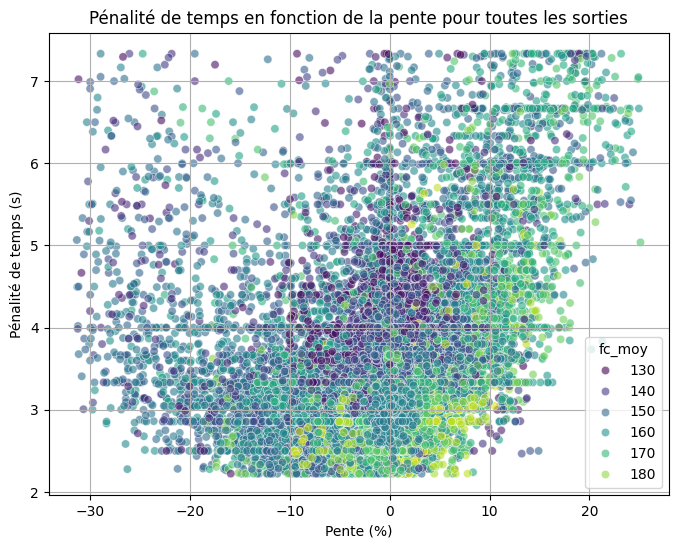

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


fc_min = 130
fc_max = 220
tableau_df = tableau_df[(tableau_df["fc_moy"] >= fc_min) & (tableau_df["fc_moy"] <= fc_max)]


pente_q_low = tableau_df["pente"].quantile(0.0001)
pente_q_high = tableau_df["pente"].quantile(0.999999999)
delta_t_q_low = tableau_df["delta_t_s"].quantile(0.0001)
delta_t_q_high = tableau_df["delta_t_s"].quantile(0.9999)

# Filtrer
tableau_df = tableau_df[(tableau_df["pente"] >= pente_q_low) & (tableau_df["pente"] <= pente_q_high)]
tableau_df = tableau_df[(tableau_df["delta_t_s"] >= delta_t_q_low) & (tableau_df["delta_t_s"] <= delta_t_q_high)]

# Nuage de points : vitesse en fonction de la pente
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=tableau_df,
    x="pente",
    y="delta_t_s",
    hue="fc_moy",
    palette="viridis",
    alpha=0.6
)
plt.xlabel("Pente (%)")
plt.ylabel("Pénalité de temps (s)")
plt.title("Pénalité de temps en fonction de la pente pour toutes les sorties")
plt.grid(True)
plt.show()